In [1]:
%config InlineBackend.figure_formats=['svg']
import numpy as np
import scipy
import scipy.sparse as sparse
import cvxpy as cp
import matplotlib.pyplot as plt
import only_prop_only_nuclear_norm as api
import time
import math


np.random.seed(0)

In [2]:
# Parameters used during optimization
N_omega = 21
omega = np.linspace(-2, 2, N_omega)
delta_omega = np.abs(omega[1] - omega[0])
N_z = 6
z = np.linspace(0, 5*10**-3, N_z)
delta_z = np.abs(z[1] - z[0])
delta_k = 1.j*np.diag(omega)
n = 0.5
beta_weight = 300.
#np.load("nico_14_may_no_herm_beta_weight_70_point_7.npy")#
end_product = np.load("nico_14_may_n_0_point_5_no_herm_beta_weight_300.npy")
#np.load("nico_14_may_no_herm_beta_weight_70_point_7.npy") #np.load("nico_14_may_feas_greater_than_onega.npy")
U_plus = [end_product[(2*N_z - 1)*N_omega:(2*N_z)*N_omega, i*N_omega:(i + 1)*N_omega] for i in range(N_z - 1)]
U_minus = [end_product[(2*N_z - 1)*N_omega:(2*N_z)*N_omega, (N_z - 1 + i)*N_omega:(N_z + i)*N_omega] for i in range(N_z - 1)]
quad_U_plus = [end_product[i*N_omega:(i + 1)*N_omega, i*N_omega:(i + 1)*N_omega] for i in range(N_z - 1)]
quad_U_minus = [end_product[(N_z - 1 + i)*N_omega:(N_z + i)*N_omega, (N_z - 1 + i)*N_omega:(N_z + i)*N_omega] for i in range(N_z - 1)]
pump_U_plus = [end_product[(2*N_z - 2)*N_omega:(2*N_z - 1)*N_omega, i*N_omega:(i + 1)*N_omega] for i in range(N_z - 1)]
opt_pump = end_product[(2*N_z - 1)*N_omega:(2*N_z)*N_omega, (2*N_z - 2)*N_omega:(2*N_z - 1)*N_omega]

In [14]:
approx = (1/delta_z)*((12/60)*U_plus[4] - (75/60)*U_plus[3] + (200/60)*U_plus[2] - 5*U_plus[1] + 5*U_plus[0] - (137/(60*np.sqrt(n)))*np.eye(N_omega))
true = (1/np.sqrt(n))*(delta_k + beta_weight*opt_pump).conj()

In [15]:
approx - true

array([[-7.11769434e-02-6.23447675e-05j, -3.44077560e-25+1.05380375e-19j,
         1.08668630e-11+4.36642812e-09j, -6.83282942e-25-5.60278703e-21j,
         4.37783143e-12-3.53588699e-10j,  4.29071504e-25+2.69266629e-20j,
         1.50457424e-12-1.79799656e-09j, -5.24984467e-26-1.32735126e-20j,
         1.00897068e-12-3.82878447e-09j,  5.84749099e-25-7.33421603e-20j,
         5.48006085e-13-3.58476857e-09j, -3.04850921e-26+5.56993308e-20j,
         3.31734640e-13-3.51092512e-09j, -1.38856480e-25+5.27431311e-20j,
         1.05249143e-13-1.07629165e-09j,  3.35372443e-26-4.44861049e-20j,
        -6.08402217e-13+4.06378749e-09j, -3.62222001e-26-3.02410562e-20j,
        -1.93423055e-12+1.05092411e-08j, -8.92626054e-25+2.54024366e-20j,
        -5.76516612e-12-1.36581871e-08j],
       [ 4.56334734e-25-1.05379595e-19j, -7.11769434e-02-5.61102898e-05j,
         7.57000785e-26-1.92730557e-20j,  1.42303946e-11+1.78379734e-08j,
        -5.79246265e-26-7.27199609e-20j,  4.63629135e-13+1.43644669e-0

In [4]:
# Value of objective function
0.5*sum(scipy.linalg.svd(U_plus[-1] - U_minus[-1])[1])

0.5265242211270815

In [5]:
# True value of n: n = 0.002141272, not enough relations between block of U_+U_+dagger
theoretical_plus = (1/np.sqrt(n))*scipy.linalg.expm((delta_k + beta_weight*opt_pump)*z[-1])
theoretical_minus = (1/np.sqrt(n))*scipy.linalg.expm((delta_k - beta_weight*opt_pump)*z[-1])
0.25*np.trace(theoretical_plus@theoretical_plus.conj().T + theoretical_minus@theoretical_minus.conj().T - (2/n)*np.eye(N_omega)) 

(0.05372518126137127+0j)

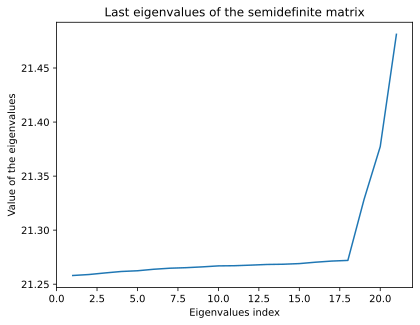

In [6]:
# Eigenvalues evaluation of variable
plt.title("Last eigenvalues of the semidefinite matrix")
plt.xlabel("Eigenvalues index")
plt.ylabel("Value of the eigenvalues")
plt.plot(np.linspace(1, N_omega, N_omega),scipy.linalg.eigvalsh(end_product)[(2*N_z - 1)*N_omega:])

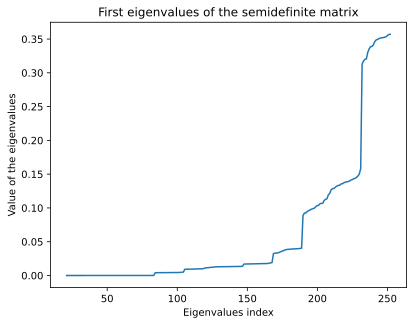

In [7]:
# If the eigenvalues other than the first N_omega are 0, semidefintie relaxation very tight
plt.title("First eigenvalues of the semidefinite matrix")
plt.xlabel("Eigenvalues index")
plt.ylabel("Value of the eigenvalues")
plt.plot(np.linspace(N_omega, 2*N_z*N_omega, (2*N_z - 1)*N_omega),scipy.linalg.eigvalsh(end_product)[:(2*N_z - 1)*N_omega])

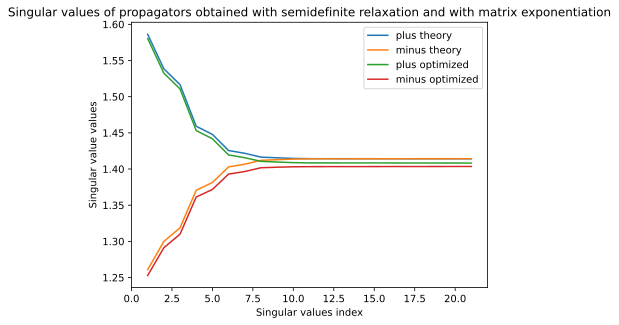

In [8]:
# The optimization results still follow the physics, albeit some difference
# Singular values of U_+ and U_-, optimized and theoretical
theory_U_plus = (1/np.sqrt(n))*scipy.linalg.expm((delta_k + beta_weight*opt_pump)*z[-1])
theory_U_minus = (1/np.sqrt(n))*scipy.linalg.expm((delta_k - beta_weight*opt_pump)*z[-1])
plt.title("Singular values of propagators obtained with semidefinite relaxation and with matrix exponentiation")
plt.xlabel("Singular values index")
plt.ylabel("Singular value values")
plt.plot(np.linspace(1, N_omega, N_omega), scipy.linalg.svd(theory_U_plus)[1], label = "plus theory")
plt.plot(np.linspace(1, N_omega, N_omega), np.sort(scipy.linalg.svd(theory_U_minus)[1]), label = "minus theory")
plt.plot(np.linspace(1, N_omega, N_omega), scipy.linalg.svd(U_plus[4])[1], label = "plus optimized")
plt.plot(np.linspace(1, N_omega, N_omega), np.sort(scipy.linalg.svd(U_minus[4])[1]), label = "minus optimized")
plt.legend()

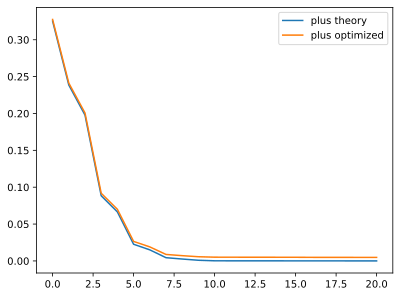

In [9]:
# Singular values of the difference between the exponential and the optimized between U_+ and U_-
plt.plot(scipy.linalg.svd(theory_U_plus - theory_U_minus)[1], label = "plus theory")
plt.plot(scipy.linalg.svd(U_plus[4] - U_minus[4])[1], label = "plus optimized")
plt.legend()

In [10]:
# Frobenius norm between the matrix exponential and the optimal thing... 98.7 percent fidelity
1 - np.sqrt(np.trace((U_plus[4] - theoretical_plus)@(U_plus[4] - theoretical_plus).conj().T))/np.sqrt(np.trace(theoretical_plus@theoretical_plus.conj().T))

(0.9870466520386927+0j)

In [11]:
np.max(np.abs(np.real(U_plus[4].conj() - theoretical_plus)))

0.006044575961888787